# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [51]:
# Import libraries

# Core data manipulation libraries
import pandas as pd
import numpy as np
import os

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Deep learning (Keras/TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM, GRU

# Preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [27]:
# Define a function to load data and aggregate them
def load_and_combine_stock_data(file_map):
    """
    Loads CSV files for each stock, renames columns uniquely per stock, and merges them into a single DataFrame.

    Parameters:
        file_map (dict): A dictionary where keys are stock tickers (e.g., 'AMZN') and values are file paths.

    Returns:
        combined_df (DataFrame): A single DataFrame containing all stock data merged on 'Date'.
    """
    from functools import reduce  # To merge multiple DataFrames
    dataframes = []  # To store individual stock DataFrames

    for ticker, filepath in file_map.items():
        # Load CSV
        df = pd.read_csv(filepath)
        
        # Convert 'Date' column to datetime for consistency and sorting
        df['Date'] = pd.to_datetime(df['Date'])
        df.sort_values('Date', inplace=True)

        # Rename columns to avoid collision during merge
        df.rename(columns={
            'Open': f'Open_{ticker}',
            'High': f'High_{ticker}',
            'Low': f'Low_{ticker}',
            'Close': f'Close_{ticker}',
            'Volume': f'Volume_{ticker}',
            'Name': f'Name_{ticker}'
        }, inplace=True)

        # Append to list
        dataframes.append(df)

    # Merge all DataFrames on 'Date' column using outer join to retain all dates
    combined_df = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), dataframes)

    # Final sorting by date
    combined_df.sort_values('Date', inplace=True)

    return combined_df


In [28]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

data_path = 'RNN_Stocks_Data'  # Folder where all stock CSVs are stored

# Map of stock tickers to their respective file paths
file_map = {
    'AMZN': os.path.join(data_path, 'AMZN_stocks_data.csv'),
    'GOOGL': os.path.join(data_path, 'GOOGL_stocks_data.csv'),
    'IBM': os.path.join(data_path, 'IBM_stocks_data.csv'),
    'MSFT': os.path.join(data_path, 'MSFT_stocks_data.csv')
}


In [29]:
# View specifics of the data

#load annd merge all stock dataset into one dataframe
stock_df = load_and_combine_stock_data(file_map)

# View the first 5 rows of the combined stock DataFrame to understand its structure
print(stock_df.head())

# Print the total number of rows and columns in the dataset
print("Shape of dataset:", stock_df.shape)

# Check for missing values in each column to identify if data cleaning is needed
print("Missing values:\n", stock_df.isnull().sum())


        Date  Open_AMZN  High_AMZN  Low_AMZN  Close_AMZN  Volume_AMZN  \
0 2006-01-03      47.47      47.85     46.25       47.58    7582127.0   
1 2006-01-04      47.48      47.73     46.69       47.25    7440914.0   
2 2006-01-05      47.16      48.20     47.11       47.65    5417258.0   
3 2006-01-06      47.97      48.58     47.32       47.87    6154285.0   
4 2006-01-09      46.55      47.10     46.40       47.08    8945056.0   

  Name_AMZN  Open_GOOGL  High_GOOGL  Low_GOOGL  ...  Low_IBM  Close_IBM  \
0      AMZN      211.47      218.05     209.32  ...    80.81      82.06   
1      AMZN      222.17      224.70     220.09  ...    81.33      81.95   
2      AMZN      223.22      226.00     220.97  ...    81.00      82.50   
3      AMZN      228.66      235.49     226.85  ...    83.41      84.95   
4      AMZN      233.44      236.94     230.70  ...    83.38      83.73   

  Volume_IBM  Name_IBM  Open_MSFT  High_MSFT  Low_MSFT  Close_MSFT  \
0   11715200       IBM      26.25      2

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [30]:
# Handle Missing Values


# First, fill forward (propagate last valid observation forward to next valid)
stock_df.fillna(method='ffill', inplace=True)

# Then, fill backward (propagate next valid observation backward to previous missing)
stock_df.fillna(method='bfill', inplace=True)

# Optional: check if any missing values remain after filling both directions
missing_after_fill = stock_df.isnull().sum().sum()
if missing_after_fill == 0:
    print("✅ All missing values handled successfully.")
else:
    print(f"⚠️ Warning: {missing_after_fill} missing values still remain.")

# Display the final shape of the cleaned DataFrame
print("Combined DataFrame shape:", stock_df.shape)

# Show the top 5 rows to inspect final data after cleaning
print(stock_df.head())


✅ All missing values handled successfully.
Combined DataFrame shape: (3020, 25)
        Date  Open_AMZN  High_AMZN  Low_AMZN  Close_AMZN  Volume_AMZN  \
0 2006-01-03      47.47      47.85     46.25       47.58    7582127.0   
1 2006-01-04      47.48      47.73     46.69       47.25    7440914.0   
2 2006-01-05      47.16      48.20     47.11       47.65    5417258.0   
3 2006-01-06      47.97      48.58     47.32       47.87    6154285.0   
4 2006-01-09      46.55      47.10     46.40       47.08    8945056.0   

  Name_AMZN  Open_GOOGL  High_GOOGL  Low_GOOGL  ...  Low_IBM  Close_IBM  \
0      AMZN      211.47      218.05     209.32  ...    80.81      82.06   
1      AMZN      222.17      224.70     220.09  ...    81.33      81.95   
2      AMZN      223.22      226.00     220.97  ...    81.00      82.50   
3      AMZN      228.66      235.49     226.85  ...    83.41      84.95   
4      AMZN      233.44      236.94     230.70  ...    83.38      83.73   

  Volume_IBM  Name_IBM  Open_M

C:\Users\Adeeb Khan\AppData\Local\Temp\ipykernel_93904\2510644218.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_df.fillna(method='ffill', inplace=True)
C:\Users\Adeeb Khan\AppData\Local\Temp\ipykernel_93904\2510644218.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_df.fillna(method='bfill', inplace=True)


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

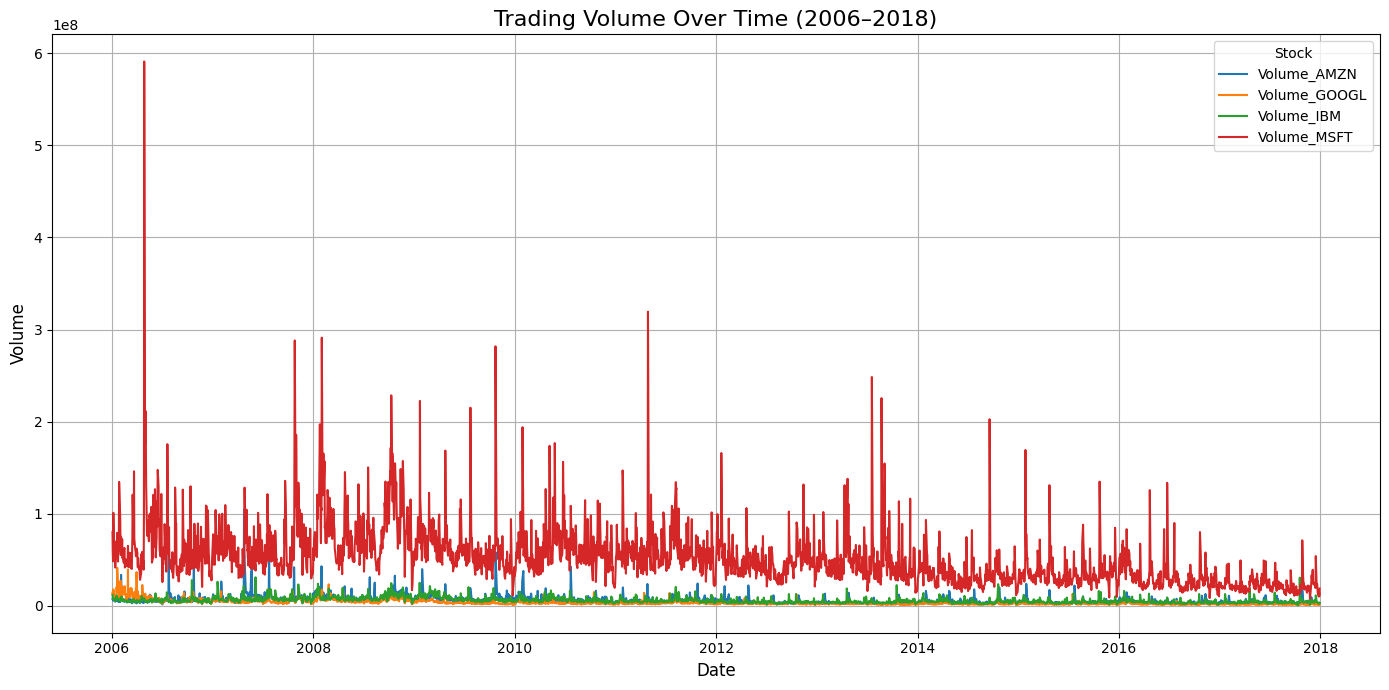

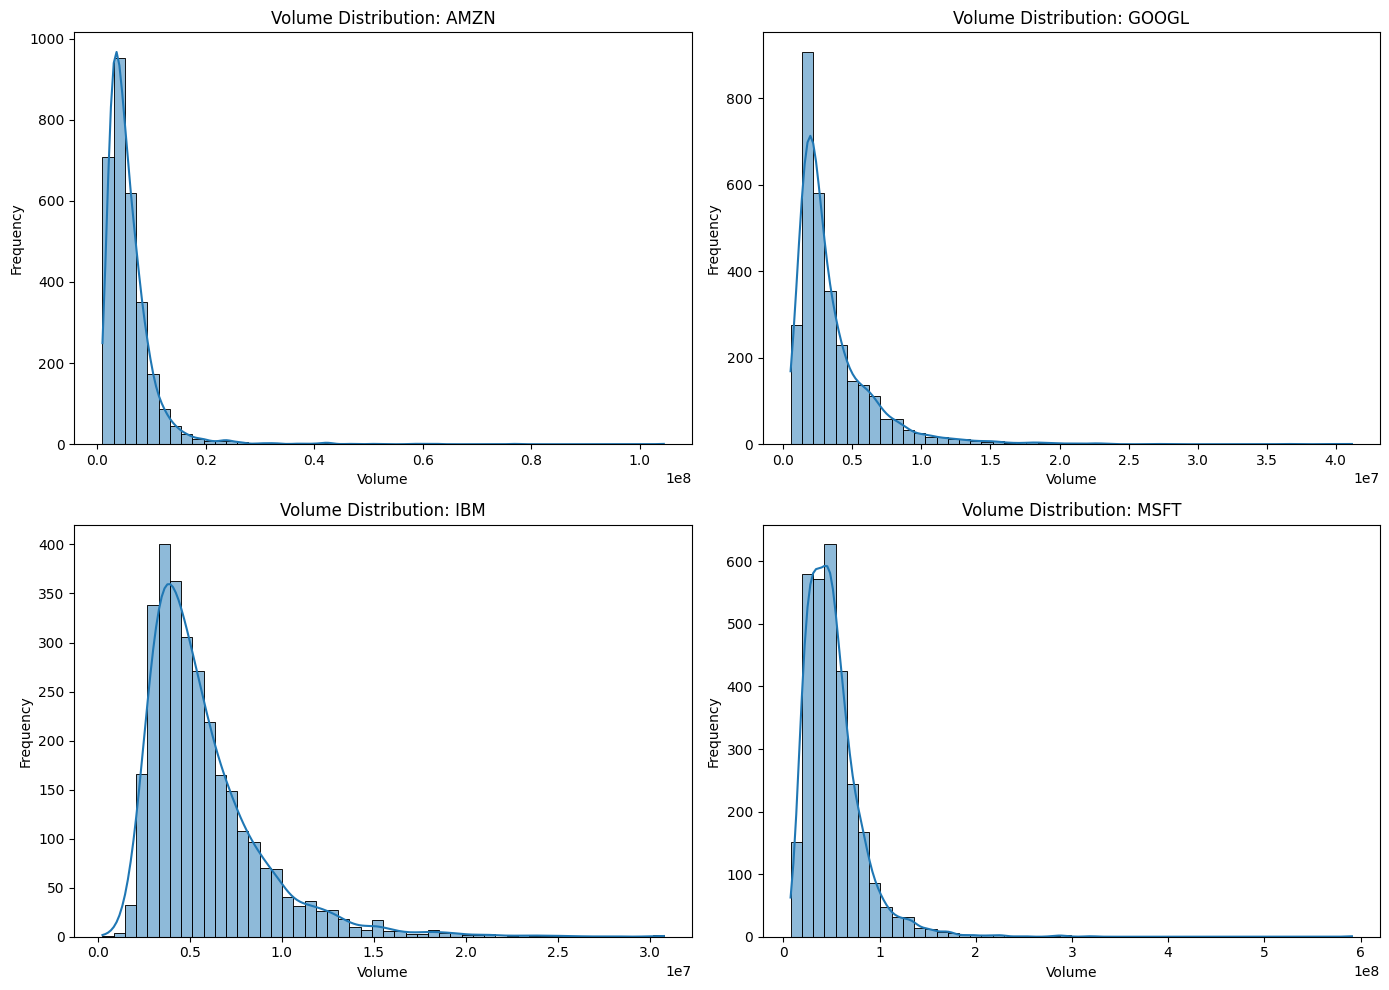

In [31]:
# Frequency distribution of volumes

plt.figure(figsize=(14, 7))

# Plot only volume columns over time
for column in stock_df.columns:
    if 'Volume' in column:
        plt.plot(stock_df['Date'], stock_df[column], label=column, linewidth=1.5)

plt.title('Trading Volume Over Time (2006–2018)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.legend(title='Stock', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 10))

# Define volume columns explicitly
volume_columns = ['Volume_AMZN', 'Volume_GOOGL', 'Volume_IBM', 'Volume_MSFT']

# Create histograms for each stock's volume
for i, column in enumerate(volume_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(stock_df[column], bins=50, kde=True)
    plt.title(f'Volume Distribution: {column.split("_")[1]}')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()




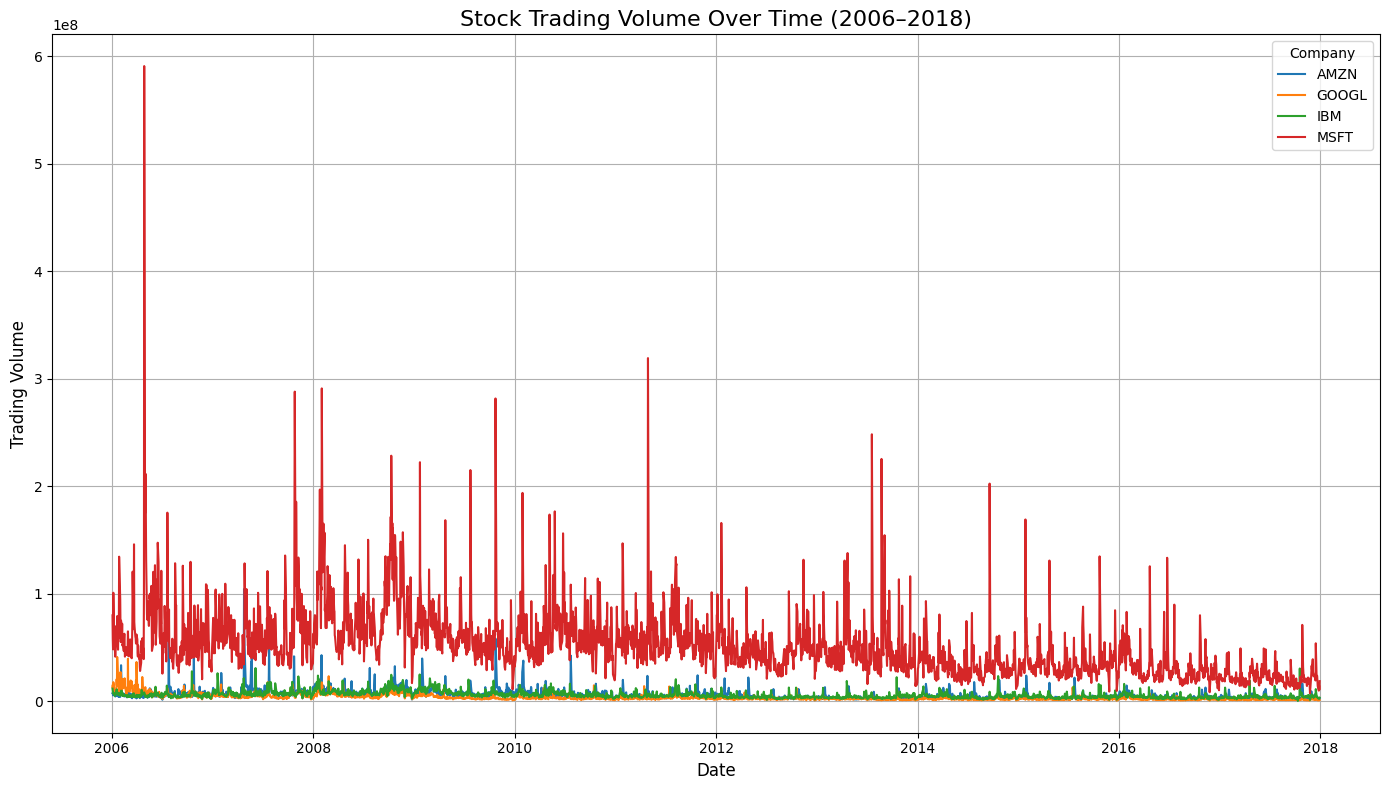

In [32]:
# Stock volume variation over time

plt.figure(figsize=(14, 8))

# Plot each stock's trading volume over time
plt.plot(stock_df['Date'], stock_df['Volume_AMZN'], label='AMZN', linewidth=1.5)
plt.plot(stock_df['Date'], stock_df['Volume_GOOGL'], label='GOOGL', linewidth=1.5)
plt.plot(stock_df['Date'], stock_df['Volume_IBM'], label='IBM', linewidth=1.5)
plt.plot(stock_df['Date'], stock_df['Volume_MSFT'], label='MSFT', linewidth=1.5)

# Add labels and a title to the plot
plt.title('Stock Trading Volume Over Time (2006–2018)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Trading Volume', fontsize=12)

# Add legend to differentiate each stock
plt.legend(title='Company', fontsize=10)

# Add grid and layout adjustment for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

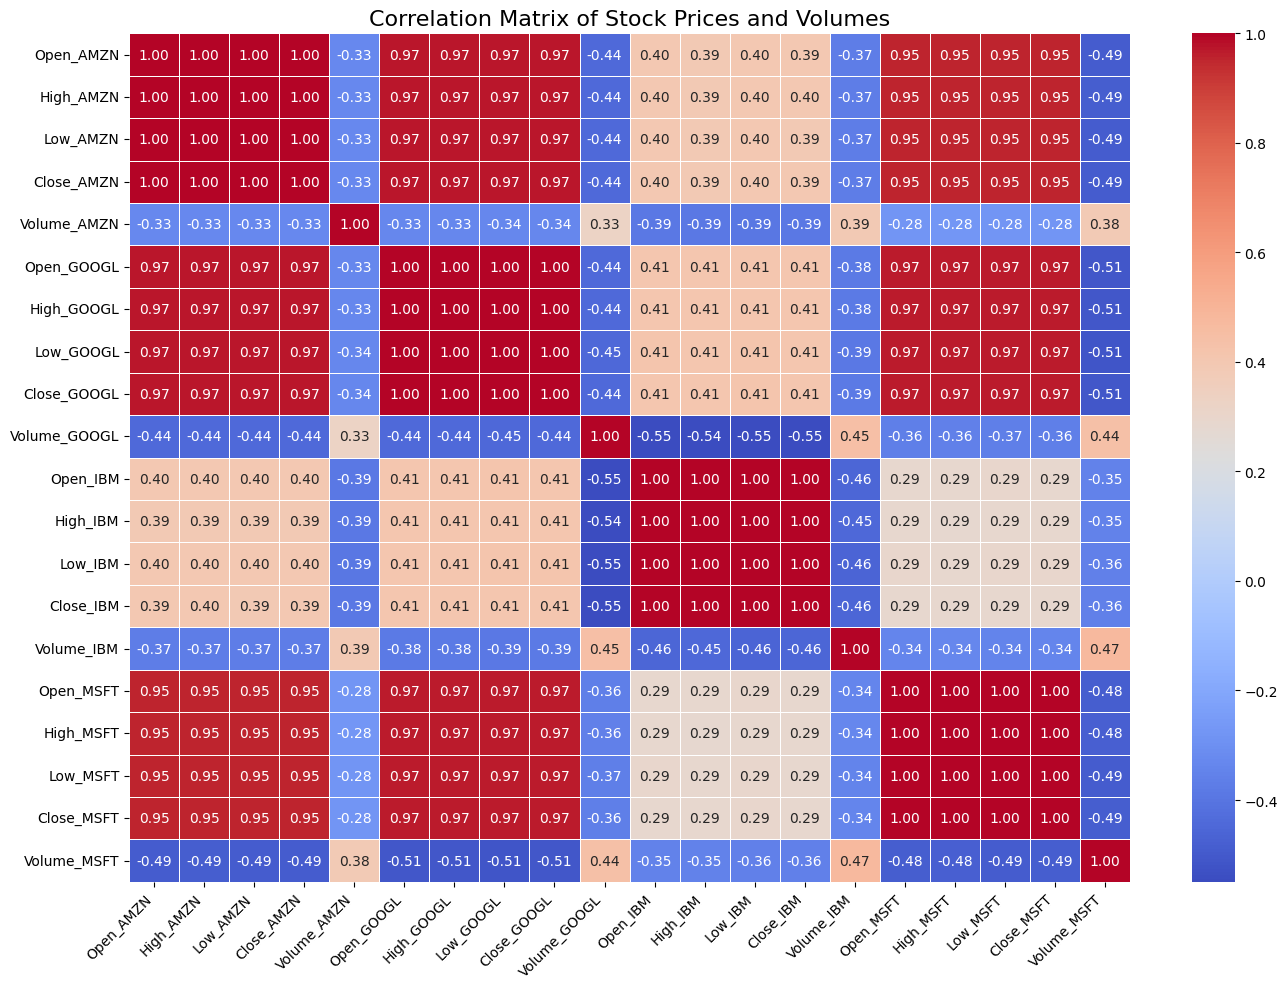

In [33]:
# Analyse correlations

# Step 1: Filter only numeric columns (exclude 'Date' or any non-numeric)
numeric_df = stock_df.select_dtypes(include='number')

# Step 2: Compute the correlation matrix between numeric features
correlation_matrix = numeric_df.corr()

# Step 3: Plot the heatmap to visualize correlations
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

# Formatting the heatmap
plt.title('Correlation Matrix of Stock Prices and Volumes', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [34]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_windowed_data(df, target_names, window_size=60, stride=1):
    """
    Creates windowed sequences of feature data (X) and corresponding target values (y) for RNN training.

    Parameters:
    - df (pd.DataFrame): The full stock dataset with all company features.
    - target_names (list): List of target column names (e.g., ['Close_AMZN']).
    - window_size (int): Number of time steps in each input window.
    - stride (int): Step size for moving the window.

    Returns:
    - X_windows (list of pd.DataFrames): List of feature windows (each of shape [window_size x num_features]).
    - y_windows (np.array): Numpy array of target values for each window (each of shape [num_targets]).
    """

    X_windows = []
    y_windows = []

    # Select only numeric columns (exclude 'Date' and object columns)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Remove target columns from the input features
    feature_cols = [col for col in numeric_cols if col not in target_names]

    # Slide over the dataframe using the specified window and stride
    for start_idx in range(0, len(df) - window_size):
        if start_idx % stride != 0:
            continue  # Apply stride (skip unnecessary windows)

        end_idx = start_idx + window_size

        # Input window: shape [window_size x num_features]
        X_window = df.iloc[start_idx:end_idx][feature_cols]

        # Target values: take the next row after the window (shape [num_targets])
        y_window = df.iloc[end_idx][target_names].values

        # Append to list
        X_windows.append(X_window.reset_index(drop=True))
        y_windows.append(y_window)

    return X_windows, np.array(y_windows)


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [35]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windows(X_windows):
    """
    Scales each individual window using MinMaxScaler to avoid data leakage.

    Parameters:
    - X_windows (list of pd.DataFrames): List of input windows (each of shape [window_size x num_features]).

    Returns:
    - scaled_X (np.array): Numpy array of scaled windows (shape: [num_windows x window_size x num_features])
    """

    scaled_X = []

    for window in X_windows:
        # Initialize a new scaler for each window to prevent leakage
        scaler = MinMaxScaler()
        
        # Fit and transform the window
        scaled = scaler.fit_transform(window)
        
        # Append the scaled window to the list
        scaled_X.append(scaled)

    return np.array(scaled_X)


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [36]:
# Define a function to create input and output data points from the master DataFrame

# Define a function to create input and output data points from the master DataFrame
def generate_rnn_data(df, target_names, window_size=60, stride=1, split_ratio=0.8):
    """
    Generates RNN-ready windowed training and test datasets.

    Parameters:
    - df (pd.DataFrame): The full combined stock dataset
    - target_names (list): List of columns to predict (e.g., ['Close_AMZN'])
    - window_size (int): Number of time steps in each window
    - stride (int): Step size to move the window
    - split_ratio (float): Fraction of data to use for training (rest for testing)

    Returns:
    - X_train (np.array): Scaled training input windows
    - y_train (np.array): Training labels
    - X_test (np.array): Scaled testing input windows
    - y_test (np.array): Testing labels
    """

    # Generate unscaled X, y using windowing logic
    X_windows, y_windows = create_windowed_data(df, target_names, window_size, stride)

    # Scale each window independently
    X_scaled = scale_windows(X_windows)

    # Determine split index
    split_idx = int(len(X_scaled) * split_ratio)

    # Split into training and test sets
    X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
    y_train, y_test = y_windows[:split_idx], y_windows[split_idx:]

    return X_train, y_train, X_test, y_test


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

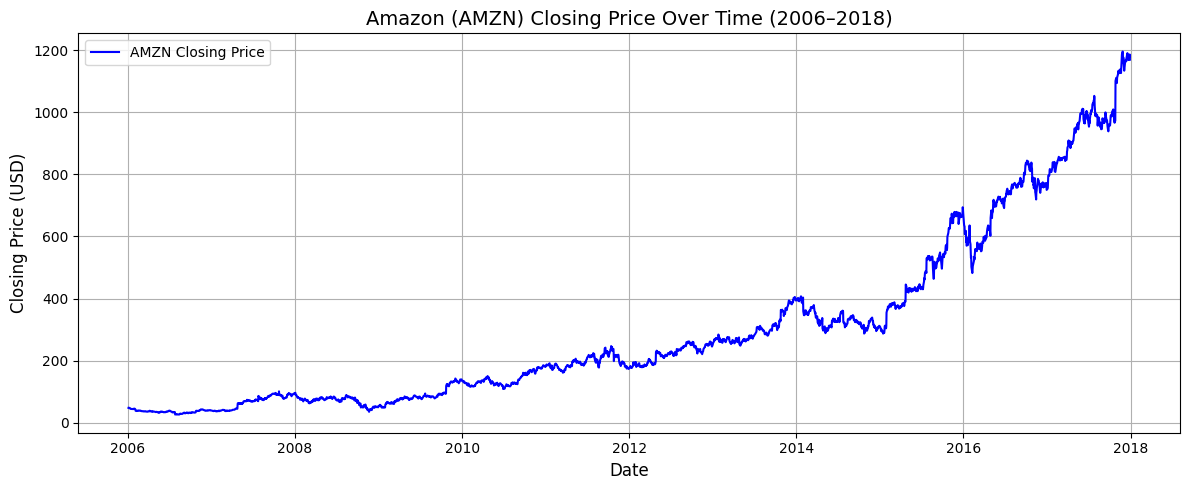

In [37]:
# Checking for patterns in different sequence lengths

plt.figure(figsize=(12, 5))

# Plot the closing price of Amazon stock
plt.plot(stock_df['Date'], stock_df['Close_AMZN'], label='AMZN Closing Price', color='blue', linewidth=1.5)

# Add plot formatting
plt.title('Amazon (AMZN) Closing Price Over Time (2006–2018)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price (USD)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [38]:
# Create data instances from the master data frame using decided window size and window stride

# Define the target columns we want to predict — closing prices of each stock
target_stocks = ['Close_AMZN', 'Close_GOOGL', 'Close_IBM', 'Close_MSFT']

# Set window size to 65 days (approximately one quarter) and stride to 5 days (one business week)
window_size = 65
window_stride = 5

# Set train-test split ratio (e.g., 80% training, 20% testing)
train_test_split_ratio = 0.8

# Generate training and testing datasets using the previously defined helper function
X_train, y_train, X_test, y_test = generate_rnn_data(
    df=stock_df,
    target_names=target_stocks,
    window_size=window_size,
    stride=window_stride,
    split_ratio=train_test_split_ratio
)



In [39]:
# Check the number of data points generated

print("Number of training windows:", len(X_train))
print("Number of training targets:", len(y_train))
print("Number of testing windows:", len(X_test))
print("Number of testing targets:", len(y_test))

X_windows, y_windows = create_windowed_data(stock_df, target_stocks, window_size=65, stride=5)
print("Total windows created:", len(X_windows))


Number of training windows: 472
Number of training targets: 472
Number of testing windows: 119
Number of testing targets: 119
Total windows created: 591


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [40]:
# Check if the datasets are compatible inputs to neural networks


# Print the shape of X_train — it should be 3D: (num_samples, window_size, num_features)
print("X_train shape:", X_train.shape)  

# Print the shape of y_train — it should be 2D: (num_samples, num_targets)
print("y_train shape:", y_train.shape)

# Similarly, print shapes for test datasets
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Check if data types are float32 or float64 — required by TensorFlow/Keras models
print("X_train dtype:", X_train.dtype)  
print("y_train dtype:", y_train.dtype)


X_train shape: (472, 65, 16)
y_train shape: (472, 4)
X_test shape: (119, 65, 16)
y_test shape: (119, 4)
X_train dtype: float64
y_train dtype: object


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [41]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def build_simple_rnn_model(input_shape, rnn_units=50, dropout=0.0, dense_units=1):
    """
    Builds and compiles a simple RNN model with configurable parameters.

    Parameters:
    - input_shape: shape of the input data (window_size, num_features)
    - rnn_units: number of RNN units
    - dropout: dropout rate after RNN layer (if any)
    - dense_units: number of output units, equal to the number of target variables

    Returns:
    - Compiled Keras model
    """
    model = Sequential()
    model.add(SimpleRNN(units=rnn_units, input_shape=input_shape))

    # Optionally add dropout to prevent overfitting
    if dropout > 0:
        model.add(tf.keras.layers.Dropout(dropout))

    # Dense layer for output
    model.add(Dense(units=dense_units))

    # Compile with Mean Squared Error loss for regression
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [42]:
# Find an optimal configuration of simple RNN

def tune_simple_rnn(X_train, y_train, X_val, y_val,
                    rnn_units_list=[50, 100],
                    dropout_list=[0.0, 0.2],
                    batch_sizes=[16, 32],
                    epochs=10):
    """
    Trains multiple RNN models using different hyperparameter combinations and returns the best one based on validation MSE.
    """
    best_model = None
    best_val_mse = float('inf')
    best_params = None

    for units in rnn_units_list:
        for dropout in dropout_list:
            for batch_size in batch_sizes:
                print(f"Training RNN: units={units}, dropout={dropout}, batch_size={batch_size}")
                
                model = build_simple_rnn_model(
                    input_shape=X_train.shape[1:],
                    rnn_units=units,
                    dropout=dropout,
                    dense_units=y_train.shape[1]
                )

                # Train the model
                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0
                )

                # Evaluate on validation set
                y_pred = model.predict(X_val)
                val_mse = mean_squared_error(y_val, y_pred)
                val_mae = mean_absolute_error(y_val, y_pred)

                print(f"→ Val MSE: {val_mse:.4f}, Val MAE: {val_mae:.4f}")

                if val_mse < best_val_mse:
                    best_val_mse = val_mse
                    best_params = (units, dropout, batch_size)
                    best_model = model

    print("\n✅ Best Configuration:")
    print(f"Units: {best_params[0]}, Dropout: {best_params[1]}, Batch Size: {best_params[2]}")
    print(f"Lowest Validation MSE: {best_val_mse:.4f}")

    return best_model, best_params


# Split training data for tuning
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)




In [43]:
X_train_sub = X_train_sub.astype(np.float32)
y_train_sub = y_train_sub.astype(np.float32)
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.float32)
print(X_train_sub.dtype)   # Should be numeric dtype, e.g. float32 or float64
print(y_train_sub.dtype)
print(X_train_sub.shape)
print(y_train_sub.shape)
print(X_val.dtype)   # Should be numeric dtype, e.g. float32 or float64
print(y_val.dtype)
print(X_val.shape)
print(y_val.shape)


float32
float32
(377, 65, 16)
(377, 4)
float32
float32
(95, 65, 16)
(95, 4)


In [44]:
# Run tuning to find the best RNN model configuration
best_rnn_model, best_rnn_params = tune_simple_rnn(
    X_train_sub, y_train_sub, X_val, y_val,
    rnn_units_list=[50, 100],
    dropout_list=[0.0, 0.2],
    batch_sizes=[16, 32],
    epochs=20
)


Training RNN: units=50, dropout=0.0, batch_size=16


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
→ Val MSE: 46556.6523, Val MAE: 155.8822
Training RNN: units=50, dropout=0.0, batch_size=32


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
→ Val MSE: 50574.0859, Val MAE: 166.7975
Training RNN: units=50, dropout=0.2, batch_size=16


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
→ Val MSE: 46435.0156, Val MAE: 155.2388
Training RNN: units=50, dropout=0.2, batch_size=32


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
→ Val MSE: 50092.7148, Val MAE: 166.2579
Training RNN: units=100, dropout=0.0, batch_size=16


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
→ Val MSE: 39342.8398, Val MAE: 136.5043
Training RNN: units=100, dropout=0.0, batch_size=32


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
→ Val MSE: 46130.4492, Val MAE: 154.8779
Training RNN: units=100, dropout=0.2, batch_size=16


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
→ Val MSE: 39548.2461, Val MAE: 137.5458
Training RNN: units=100, dropout=0.2, batch_size=32


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
→ Val MSE: 46009.1680, Val MAE: 154.4378

✅ Best Configuration:
Units: 100, Dropout: 0.0, Batch Size: 16
Lowest Validation MSE: 39342.8398


In [45]:
# Find the best configuration based on evaluation metrics

def tune_simple_rnn_with_metrics(X_train, y_train, X_val, y_val,
                                 rnn_units_list=[20, 50, 100],
                                 dropout_list=[0, 0.2, 0.5],
                                 batch_sizes=[16, 32],
                                 epochs=20):
    
    best_val_mse = float('inf')
    best_model = None
    best_params = None

    for units in rnn_units_list:
        for dropout in dropout_list:
            for batch_size in batch_sizes:
                print(f"Training: units={units}, dropout={dropout}, batch_size={batch_size}")
                
                model = build_simple_rnn_model(
                    input_shape=X_train.shape[1:], 
                    rnn_units=units,
                    dropout=dropout,
                    dense_units=y_train.shape[1]
                )
                
                model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0
                )
                
                # Predict on validation set
                y_pred_val = model.predict(X_val)
                
                # Compute MSE and MAE
                val_mse = mean_squared_error(y_val.reshape(-1, y_val.shape[-1]), y_pred_val.reshape(-1, y_pred_val.shape[-1]))
                val_mae = mean_absolute_error(y_val.reshape(-1, y_val.shape[-1]), y_pred_val.reshape(-1, y_pred_val.shape[-1]))
                
                print(f"Val MSE: {val_mse:.4f}, Val MAE: {val_mae:.4f}")
                
                # Update best model based on MSE
                if val_mse < best_val_mse:
                    best_val_mse = val_mse
                    best_model = model
                    best_params = (units, dropout, batch_size)

    print(f"\nBest Params: units={best_params[0]}, dropout={best_params[1]}, batch_size={best_params[2]}")
    print(f"Best Validation MSE: {best_val_mse:.4f}")
    
    return best_model, best_params


# Tune model
best_model, best_params = tune_simple_rnn_with_metrics(
    X_train_sub, y_train_sub, X_val, y_val,
    rnn_units_list=[20, 50, 100],
    dropout_list=[0, 0.2, 0.5],
    batch_sizes=[16, 32],
    epochs=20
)


Training: units=20, dropout=0, batch_size=16


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Val MSE: 51454.0312, Val MAE: 169.5320
Training: units=20, dropout=0, batch_size=32


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Val MSE: 53210.2344, Val MAE: 174.4302
Training: units=20, dropout=0.2, batch_size=16


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Val MSE: 51801.3594, Val MAE: 170.2059
Training: units=20, dropout=0.2, batch_size=32


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Val MSE: 53486.4688, Val MAE: 175.3855
Training: units=20, dropout=0.5, batch_size=16


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Val MSE: 51888.7891, Val MAE: 171.0160
Training: units=20, dropout=0.5, batch_size=32


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Val MSE: 53464.6367, Val MAE: 174.9269
Training: units=50, dropout=0, batch_size=16


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Val MSE: 46367.2383, Val MAE: 155.5967
Training: units=50, dropout=0, batch_size=32


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Val MSE: 50311.3047, Val MAE: 167.0566
Training: units=50, dropout=0.2, batch_size=16


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Val MSE: 46622.2852, Val MAE: 155.5784
Training: units=50, dropout=0.2, batch_size=32


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Val MSE: 50318.1797, Val MAE: 166.4006
Training: units=50, dropout=0.5, batch_size=16


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Val MSE: 46612.8672, Val MAE: 155.8574
Training: units=50, dropout=0.5, batch_size=32


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Val MSE: 50513.5781, Val MAE: 167.4632
Training: units=100, dropout=0, batch_size=16


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Val MSE: 39632.7773, Val MAE: 137.7523
Training: units=100, dropout=0, batch_size=32


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Val MSE: 46327.4766, Val MAE: 155.3096
Training: units=100, dropout=0.2, batch_size=16


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Val MSE: 39909.3516, Val MAE: 138.6548
Training: units=100, dropout=0.2, batch_size=32


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Val MSE: 46194.8242, Val MAE: 154.7887
Training: units=100, dropout=0.5, batch_size=16


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Val MSE: 39857.6172, Val MAE: 137.8220
Training: units=100, dropout=0.5, batch_size=32


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Val MSE: 46319.8398, Val MAE: 155.2511

Best Params: units=100, dropout=0, batch_size=16
Best Validation MSE: 39632.7773


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

Epoch 1/20


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3742 - val_loss: 0.1340
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1972 - val_loss: 0.2164
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1499 - val_loss: 0.2074
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1253 - val_loss: 0.1490
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1060 - val_loss: 0.2023
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1065 - val_loss: 0.1927
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1008 - val_loss: 0.1786
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0910 - val_loss: 0.1898
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0920 - val_loss: 0.1885
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0830 - val_loss: 0.2002
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0773 - val_loss: 0.1708
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0753 - val_loss: 0.1902

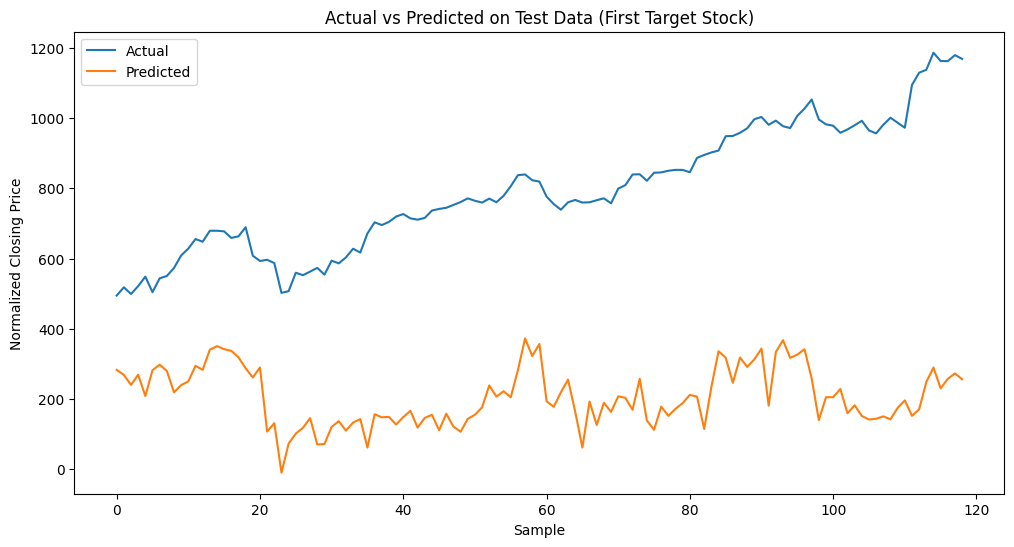

Test MSE Loss: 347080.8125


In [46]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

# Function to build simple RNN model
def build_simple_rnn_model(input_shape, rnn_units, dropout, dense_units):
    model = Sequential()
    model.add(SimpleRNN(rnn_units, input_shape=input_shape))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(dense_units))
    model.compile(optimizer='adam', loss='mse')
    return model

# Assume you already have these from tuning:
best_rnn_units = 50
best_dropout = 0.2
best_batch_size = 32
best_epochs = 20

# Convert your data to float32 numpy arrays if not already
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Build model with best hyperparameters
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = X_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = X_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# 2. Build and train model using scaled data
model = build_simple_rnn_model(
    input_shape=X_train_scaled.shape[1:], 
    rnn_units=best_rnn_units, 
    dropout=best_dropout, 
    dense_units=y_train_scaled.shape[1]
)

history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=best_epochs,
    batch_size=best_batch_size,
    validation_split=0.1,
    verbose=1
)

# 3. Predict and inverse scale
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# Plot Actual vs Predicted for one of the target stocks (for example, first target)
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='Actual')
plt.plot(y_pred[:, 0], label='Predicted')
plt.title('Actual vs Predicted on Test Data (First Target Stock)')
plt.xlabel('Sample')
plt.ylabel('Normalized Closing Price')
plt.legend()
plt.show()

# Evaluate performance on test data (MSE)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test MSE Loss: {test_loss:.4f}')


Plotting the actual vs predicted values

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


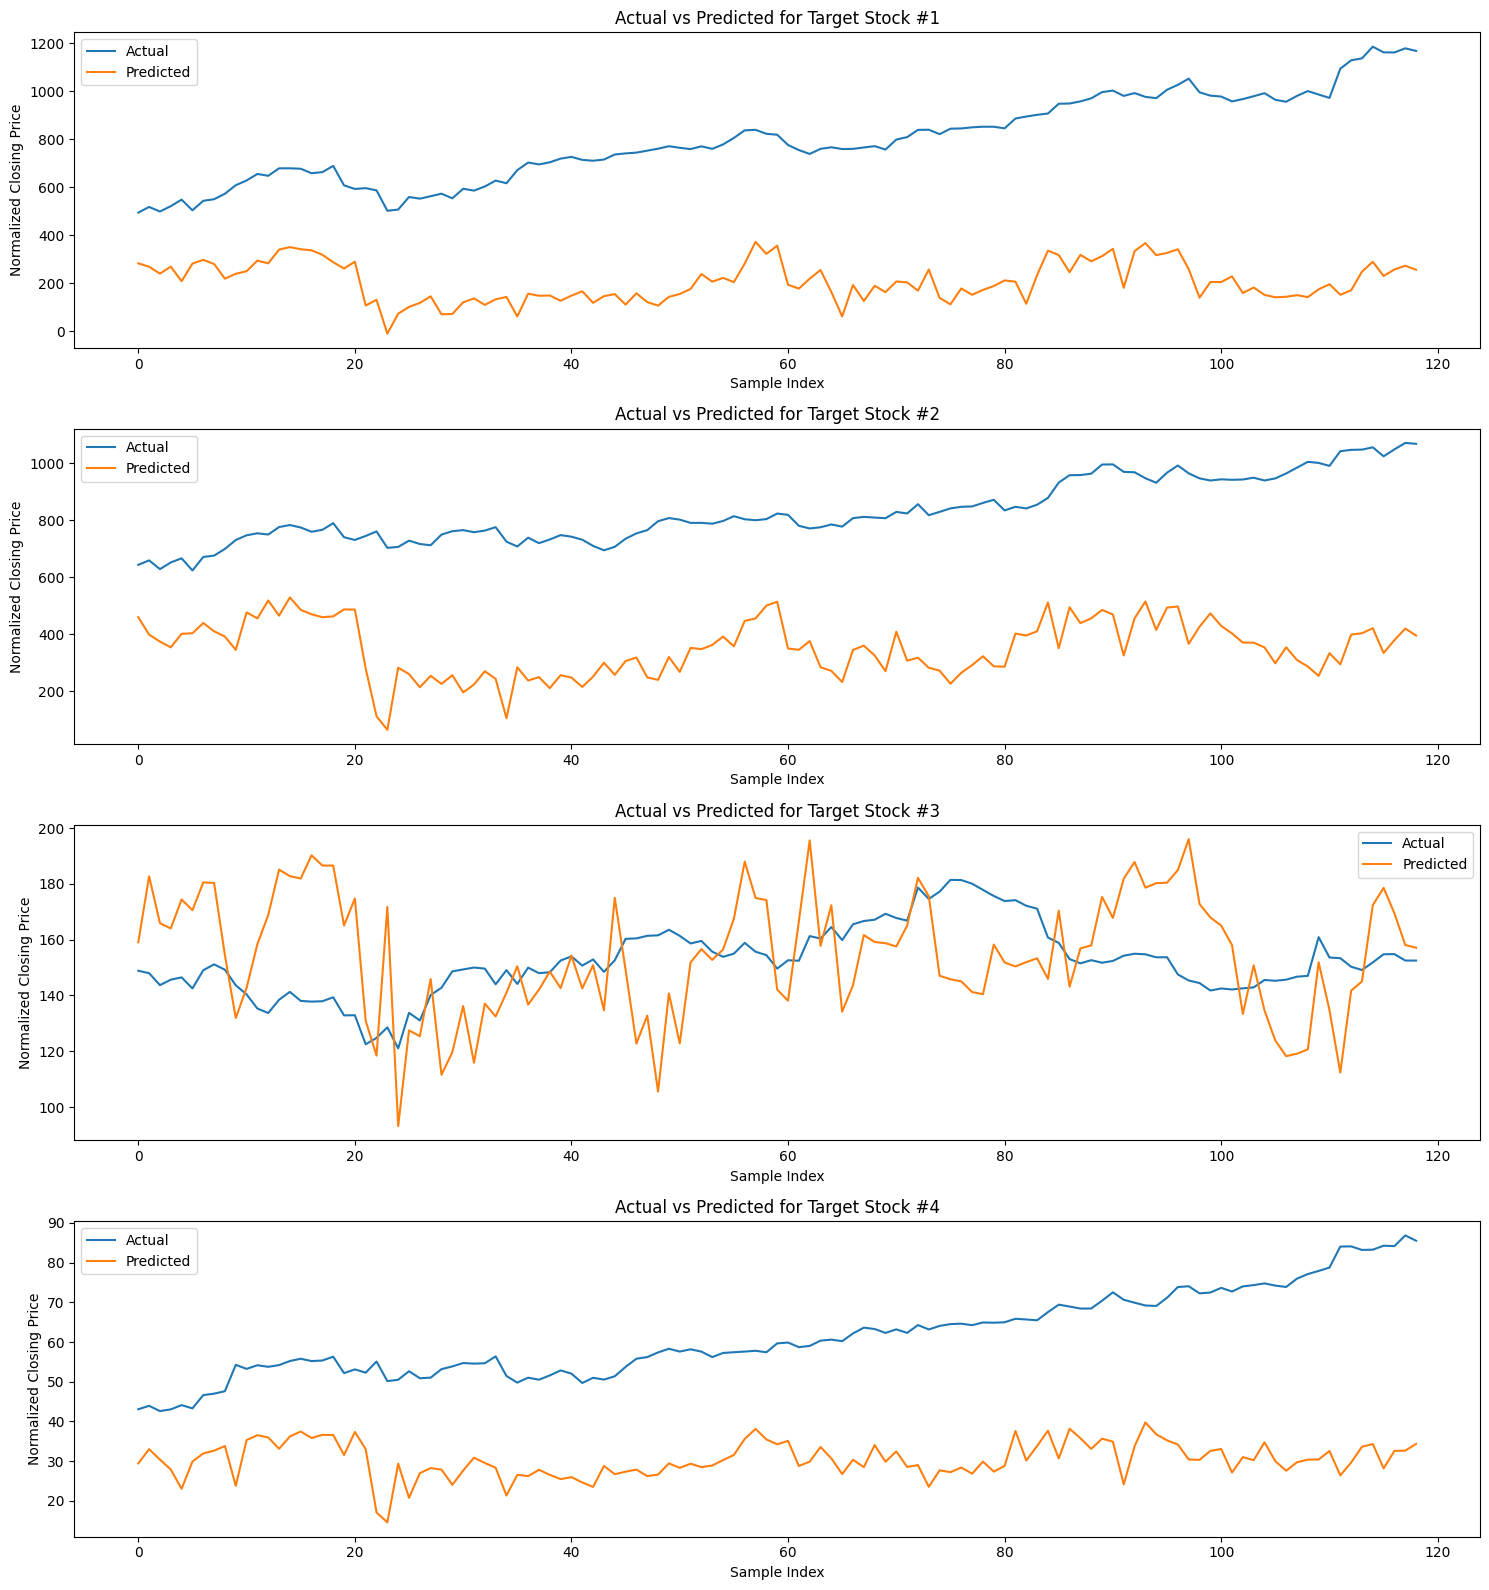

In [47]:
# Predict on the test data and plot

y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# Number of target stocks
num_targets = y_test.shape[1]

# Plot actual vs predicted for each target stock
plt.figure(figsize=(15, 4 * num_targets))

for i in range(num_targets):
    plt.subplot(num_targets, 1, i + 1)
    plt.plot(y_test[:, i], label='Actual')
    plt.plot(y_pred[:, i], label='Predicted')
    plt.title(f'Actual vs Predicted for Target Stock #{i+1}')
    plt.xlabel('Sample Index')
    plt.ylabel('Normalized Closing Price')
    plt.legend()

plt.tight_layout()
plt.show()


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [48]:
# Compute the performance of the model on the testing data set

y_pred = model.predict(X_test)

# Initialize lists to store metrics for each target
mse_list = []
rmse_list = []
mae_list = []

num_targets = y_test.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    
    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    
    print(f"Target Stock #{i+1}: MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}")

# Optional: average metrics across all targets
print(f"\nAverage MSE: {np.mean(mse_list):.4f}")
print(f"Average RMSE: {np.mean(rmse_list):.4f}")
print(f"Average MAE: {np.mean(mae_list):.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Target Stock #1: MSE=662288.6875, RMSE=813.8112, MAE=794.2214
Target Stock #2: MSE=699037.5000, RMSE=836.0846, MAE=828.5585
Target Stock #3: MSE=23166.6914, RMSE=152.2061, MAE=151.7072
Target Stock #4: MSE=3830.2893, RMSE=61.8893, MAE=60.9685

Average MSE: 347080.7921
Average RMSE: 465.9978
Average MAE: 458.8639


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [49]:
# # Define a function to create a model and specify default values for hyperparameters

def build_advanced_rnn_model(
    input_shape,
    rnn_type='LSTM',          # 'LSTM' or 'GRU'
    rnn_units=50,             # number of units per RNN layer
    num_layers=1,             # number of stacked RNN layers
    dropout=0.0,              # dropout rate after RNN layers
    recurrent_dropout=0.0,    # recurrent dropout rate inside RNN cells
    dense_units=1             # output dimension (number of target variables)
):
    model = Sequential()
    
    RNNLayer = LSTM if rnn_type == 'LSTM' else GRU
    
    # Add RNN layers, set return_sequences=True except for last RNN layer
    for i in range(num_layers):
        return_sequences = i < (num_layers - 1)
        if i == 0:
            # first layer needs input shape
            model.add(RNNLayer(
                units=rnn_units, 
                dropout=dropout,
                recurrent_dropout=recurrent_dropout,
                return_sequences=return_sequences,
                input_shape=input_shape
            ))
        else:
            model.add(RNNLayer(
                units=rnn_units,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout,
                return_sequences=return_sequences
            ))
    
    # Output dense layer
    model.add(Dense(dense_units))
    
    model.compile(optimizer='adam', loss='mse')
    return model


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [52]:
# Find an optimal configuration

def tune_advanced_rnn(
    X_train, y_train, X_val, y_val,
    rnn_types=['LSTM', 'GRU'],
    rnn_units_list=[50, 100],
    num_layers_list=[1, 2],
    dropout_list=[0.0, 0.2],
    recurrent_dropout_list=[0.0, 0.1],
    batch_sizes=[16, 32],
    epochs=20
):
    best_val_loss = float('inf')
    best_model = None
    best_params = None

    for rnn_type in rnn_types:
        for units in rnn_units_list:
            for num_layers in num_layers_list:
                for dropout in dropout_list:
                    for rec_dropout in recurrent_dropout_list:
                        for batch_size in batch_sizes:
                            print(f"Training: type={rnn_type}, units={units}, layers={num_layers}, dropout={dropout}, rec_dropout={rec_dropout}, batch={batch_size}")
                            
                            model = build_advanced_rnn_model(
                                input_shape=X_train.shape[1:],
                                rnn_type=rnn_type,
                                rnn_units=units,
                                num_layers=num_layers,
                                dropout=dropout,
                                recurrent_dropout=rec_dropout,
                                dense_units=y_train.shape[1]
                            )
                            
                            history = model.fit(
                                X_train, y_train,
                                validation_data=(X_val, y_val),
                                epochs=epochs,
                                batch_size=batch_size,
                                verbose=0
                            )
                            
                            val_loss = history.history['val_loss'][-1]
                            print(f"Validation loss: {val_loss:.4f}")
                            
                            if val_loss < best_val_loss:
                                best_val_loss = val_loss
                                best_model = model
                                best_params = {
                                    'rnn_type': rnn_type,
                                    'units': units,
                                    'num_layers': num_layers,
                                    'dropout': dropout,
                                    'recurrent_dropout': rec_dropout,
                                    'batch_size': batch_size,
                                    'epochs': epochs
                                }
    
    print(f"\nBest validation loss: {best_val_loss:.4f}")
    print(f"Best hyperparameters: {best_params}")
    
    return best_model, best_params


best_model, best_params = tune_advanced_rnn(
    X_train_sub, y_train_sub, X_val, y_val,
    rnn_types=['LSTM', 'GRU'],
    rnn_units_list=[50, 100],
    num_layers_list=[1, 2],
    dropout_list=[0, 0.2],
    recurrent_dropout_list=[0, 0.1],
    batch_sizes=[16, 32],
    epochs=10  # set small epochs for tuning speed, increase later
)


Training: type=LSTM, units=50, layers=1, dropout=0, rec_dropout=0, batch=16


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation loss: 49905.8086
Training: type=LSTM, units=50, layers=1, dropout=0, rec_dropout=0, batch=32
Validation loss: 52174.2422
Training: type=LSTM, units=50, layers=1, dropout=0, rec_dropout=0.1, batch=16
Validation loss: 50063.7227
Training: type=LSTM, units=50, layers=1, dropout=0, rec_dropout=0.1, batch=32
Validation loss: 52175.3477
Training: type=LSTM, units=50, layers=1, dropout=0.2, rec_dropout=0, batch=16
Validation loss: 49726.6367
Training: type=LSTM, units=50, layers=1, dropout=0.2, rec_dropout=0, batch=32
Validation loss: 52134.6055
Training: type=LSTM, units=50, layers=1, dropout=0.2, rec_dropout=0.1, batch=16
Validation loss: 50047.2617
Training: type=LSTM, units=50, layers=1, dropout=0.2, rec_dropout=0.1, batch=32
Validation loss: 52328.3672
Training: type=LSTM, units=50, layers=2, dropout=0, rec_dropout=0, batch=16
Validation loss: 49779.4961
Training: type=LSTM, units=50, layers=2, dropout=0, rec_dropout=0, batch=32
Validation loss: 52340.7070
Training: type=LSTM,

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [53]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

# Extract best params from tuning result
params = best_params

# Build the model again with best hyperparameters
final_model = build_advanced_rnn_model(
    input_shape=X_train.shape[1:],
    rnn_type=params['rnn_type'],
    rnn_units=params['units'],
    num_layers=params['num_layers'],
    dropout=params['dropout'],
    recurrent_dropout=params['recurrent_dropout'],
    dense_units=y_train.shape[1]
)

# Retrain on full training set
final_model.fit(
    X_train, y_train,
    epochs=params['epochs'],
    batch_size=params['batch_size'],
    verbose=1
)


Epoch 1/10


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 47142.8828
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 45968.7773
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 45637.2148
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 43324.4531
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 41117.9688
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 41268.5078
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 41187.3242
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 39908.6016
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 40189.8320
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 38191.1367


In [54]:
# Compute the performance of the model on the testing data set

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R2 Score: {r2:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Test MSE: 314849.4062
Test RMSE: 561.1144
Test MAE: 425.9496
Test R2 Score: -42.8424


Plotting the actual vs predicted values

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


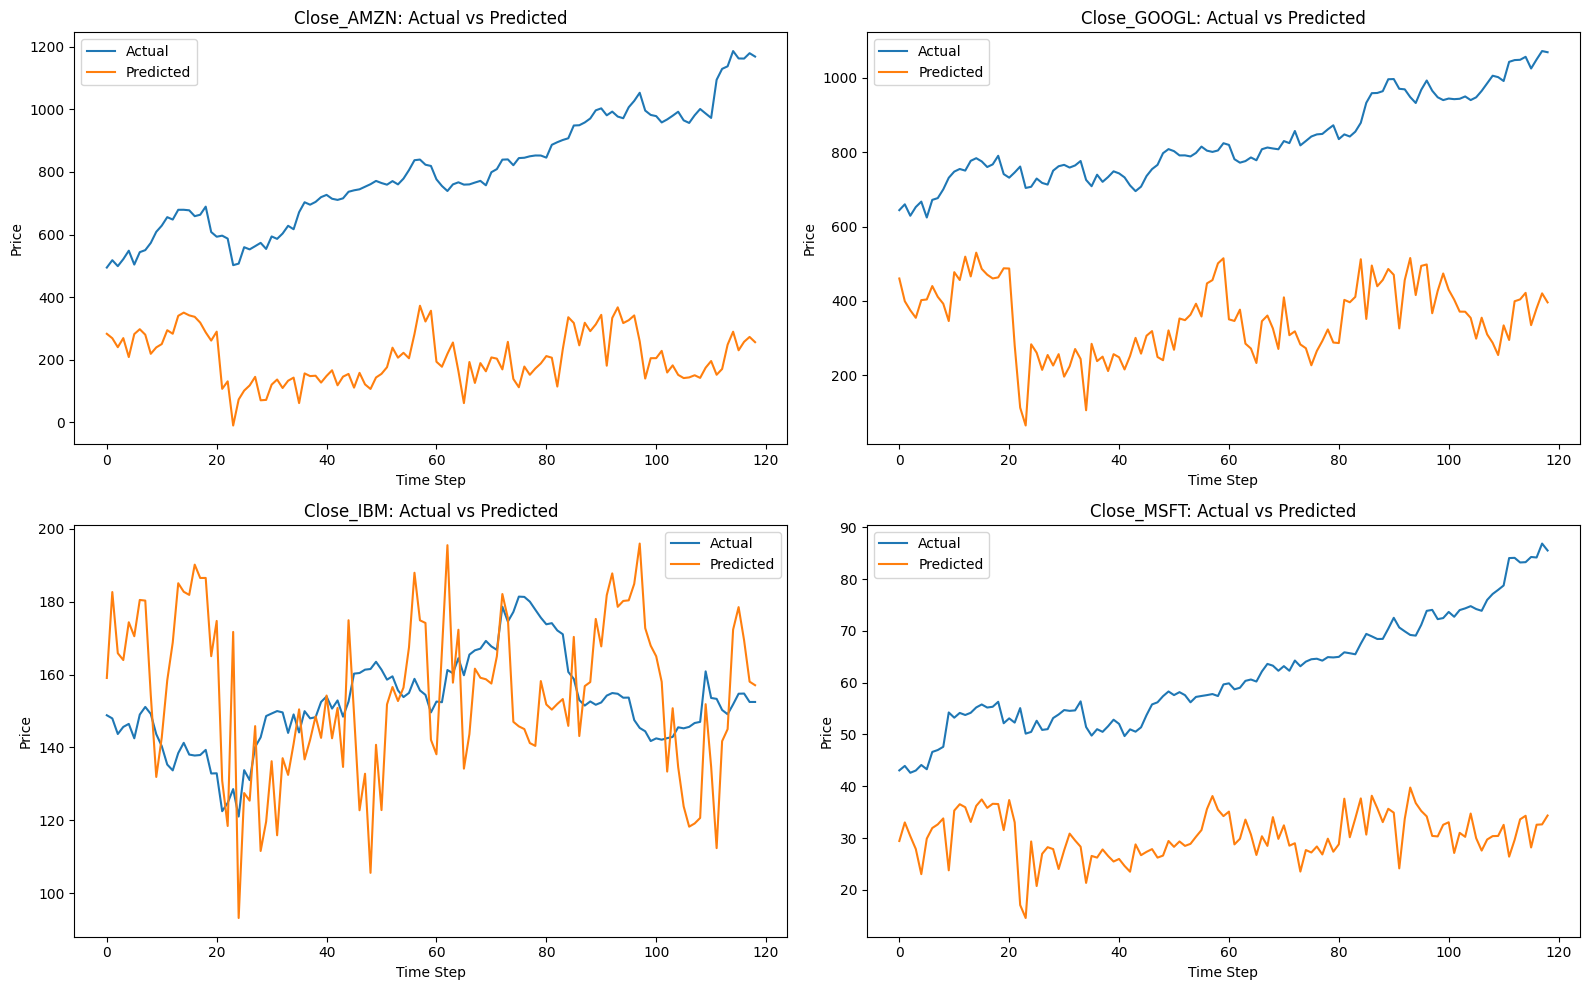

In [55]:
# Predict on the test data

target_names = ['Close_AMZN', 'Close_GOOGL', 'Close_IBM', 'Close_MSFT']

y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
# Plot actual vs predicted for each stock
plt.figure(figsize=(16, 10))

for i in range(y_test.shape[1]):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_test[:, i], label='Actual')
    plt.plot(y_pred[:, i], label='Predicted')
    plt.title(f"{target_names[i]}: Actual vs Predicted")
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()

plt.tight_layout()
plt.show()


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [56]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter

def create_multivariate_sequences(df, target_names, window_size=65, stride=5, test_size=0.2):
    data = df[target_names].dropna().values
    X, y = [], []

    for i in range(0, len(data) - window_size, stride):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])

    X, y = np.array(X), np.array(y)
    test_len = int(test_size * len(X))
    return X[:-test_len], y[:-test_len], X[-test_len:], y[-test_len:]

# Choose Close columns of all four stocks
target_names = ['Close_AMZN', 'Close_GOOGL', 'Close_IBM', 'Close_MSFT']


In [57]:
# Check the number of data points generated

# Scale the data
scaler = MinMaxScaler()
stock_df_scaled = stock_df.copy()
stock_df_scaled[target_names] = scaler.fit_transform(stock_df[target_names])

# Create training and test sets
X_train, y_train, X_test, y_test = create_multivariate_sequences(stock_df_scaled, target_names)

print(f'Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}')
print(f'Input shape: {X_train.shape}, Output shape: {y_train.shape}')


Training samples: 473, Testing samples: 118
Input shape: (473, 65, 4), Output shape: (473, 4)


### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [58]:
# Find an optimal configuration of simple RNN

from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping

best_val_loss = float('inf')
best_config = None

for units in [32, 64]:
    for lr in [0.001, 0.0005]:
        model = Sequential([
            SimpleRNN(units, activation='tanh', input_shape=X_train.shape[1:]),
            Dense(len(target_names))
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
        es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0, callbacks=[es])
        val_loss = min(history.history['val_loss'])
        print(f"Units: {units}, LR: {lr}, Val Loss: {val_loss:.6f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_config = (units, lr)


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 32, LR: 0.001, Val Loss: 0.002718
Units: 32, LR: 0.0005, Val Loss: 0.004736
Units: 64, LR: 0.001, Val Loss: 0.001666
Units: 64, LR: 0.0005, Val Loss: 0.005099


In [59]:
# Find the best configuration

print("Best configuration for Simple RNN:", best_config)


Best configuration for Simple RNN: (64, 0.001)


In [60]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the

units, lr = best_config
simple_rnn_model = Sequential([
    SimpleRNN(units, activation='tanh', input_shape=X_train.shape[1:]),
    Dense(len(target_names))
])
simple_rnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
simple_rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)


In [61]:
# Compute the performance of the model on the testing data set

y_pred = simple_rnn_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Simple RNN - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Simple RNN - MSE: 0.0110, MAE: 0.0805, R2: 0.2689


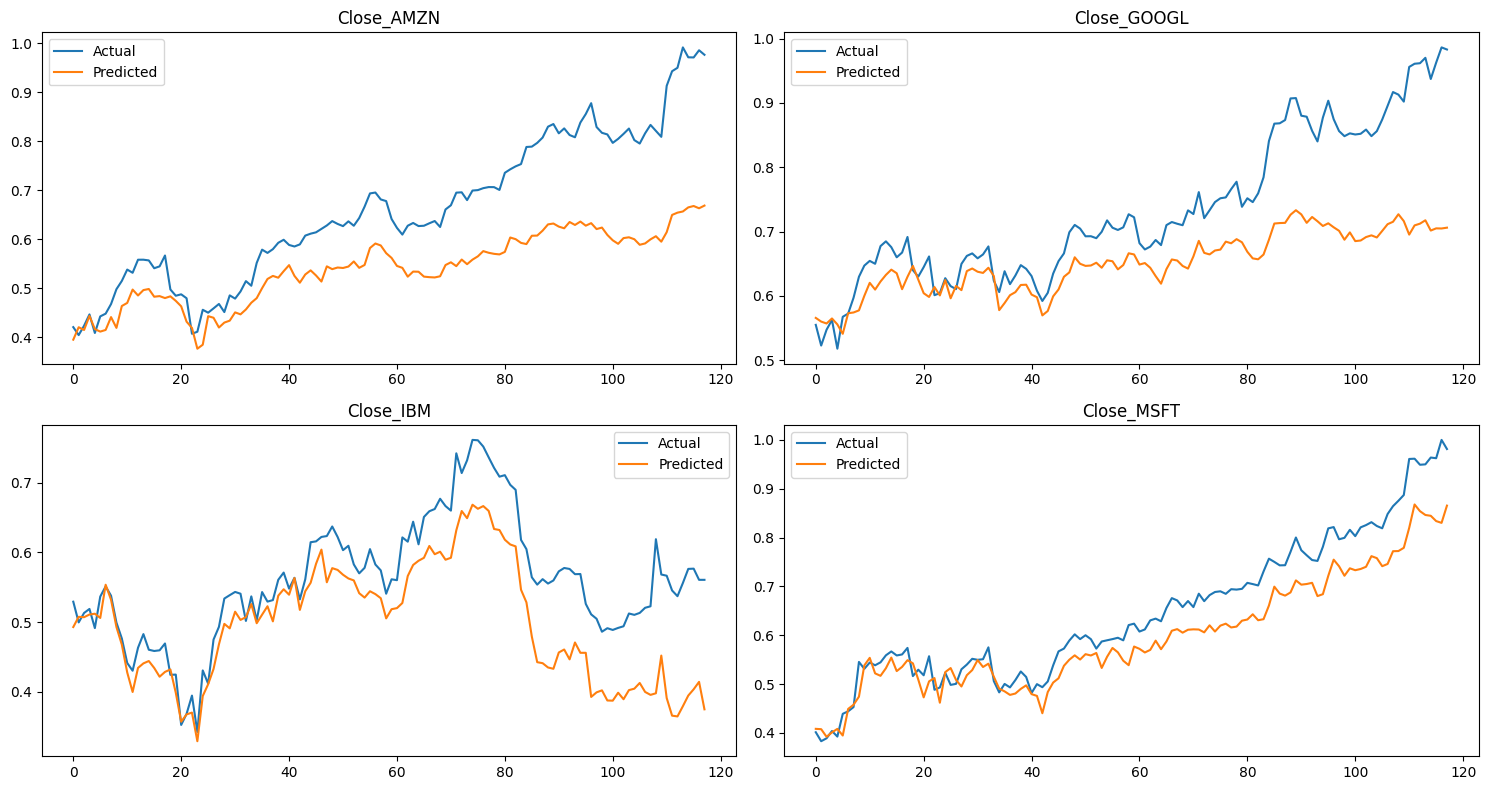

In [62]:
# Plotting the actual vs predicted values for all targets

plt.figure(figsize=(15, 8))
for i, name in enumerate(target_names):
    plt.subplot(2, 2, i+1)
    plt.plot(y_test[:, i], label='Actual')
    plt.plot(y_pred[:, i], label='Predicted')
    plt.title(name)
    plt.legend()
plt.tight_layout()
plt.show()


#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [63]:
# Find an optimal configuration of advanced RNN

from tensorflow.keras.layers import LSTM

best_val_loss_adv = float('inf')
best_config_adv = None

for units in [32, 64]:
    for lr in [0.001, 0.0005]:
        model = Sequential([
            LSTM(units, activation='tanh', input_shape=X_train.shape[1:]),
            Dense(len(target_names))
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
        es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0, callbacks=[es])
        val_loss = min(history.history['val_loss'])
        print(f"LSTM Units: {units}, LR: {lr}, Val Loss: {val_loss:.6f}")
        if val_loss < best_val_loss_adv:
            best_val_loss_adv = val_loss
            best_config_adv = (units, lr)


c:\Users\Adeeb Khan\Sankalp-RNNs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM Units: 32, LR: 0.001, Val Loss: 0.001899
LSTM Units: 32, LR: 0.0005, Val Loss: 0.013456
LSTM Units: 64, LR: 0.001, Val Loss: 0.000803
LSTM Units: 64, LR: 0.0005, Val Loss: 0.001695


In [64]:
# Find the best configuration

print("Best configuration for Advanced RNN (LSTM):", best_config_adv)


Best configuration for Advanced RNN (LSTM): (64, 0.001)


In [65]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model

units, lr = best_config_adv
lstm_model = Sequential([
    LSTM(units, activation='tanh', input_shape=X_train.shape[1:]),
    Dense(len(target_names))
])
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)


In [67]:
# Compute the performance of the model on the testing data set

y_pred_lstm = lstm_model.predict(X_test)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"LSTM - MSE: {mse_lstm:.4f}, MAE: {mae_lstm:.4f}, R2: {r2_lstm:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
LSTM - MSE: 0.0026, MAE: 0.0405, R2: 0.7703


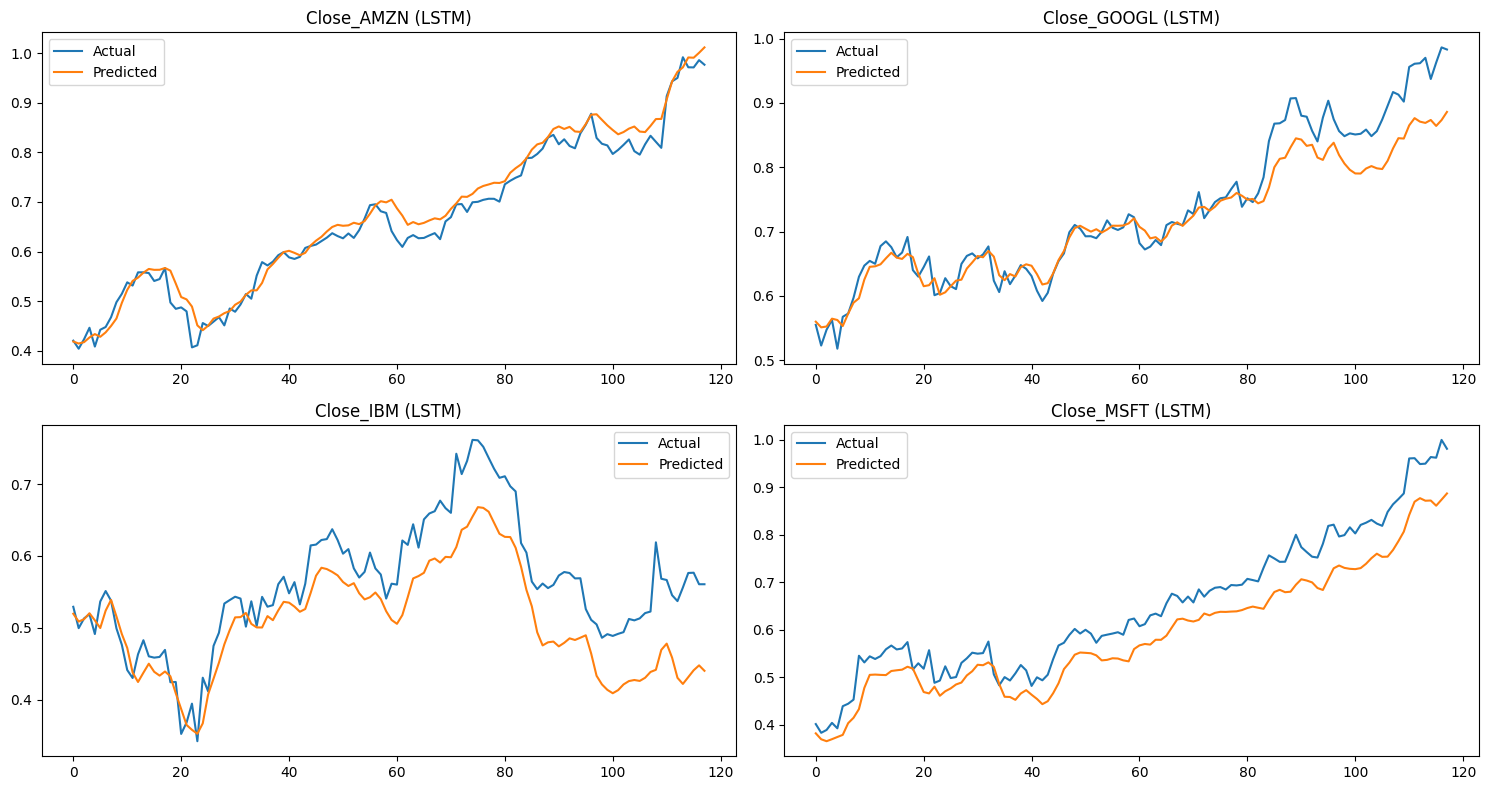

In [68]:
# Plotting the actual vs predicted values for all targets

plt.figure(figsize=(15, 8))
for i, name in enumerate(target_names):
    plt.subplot(2, 2, i+1)
    plt.plot(y_test[:, i], label='Actual')
    plt.plot(y_pred_lstm[:, i], label='Predicted')
    plt.title(name + " (LSTM)")
    plt.legend()
plt.tight_layout()
plt.show()


## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

In this project, we predicted the closing stock prices of four major companies—**Amazon (AMZN), Google (GOOGL), IBM, and Microsoft (MSFT)**—using Recurrent Neural Networks (RNNs). Here's a summary of the insights drawn from each major phase:

---

#### 🔍 **Part 1: Data Loading and Preprocessing**
- Stock data was successfully loaded and merged from individual CSVs using the `Date` column.
- Only the `Close` prices were used to keep the modeling focused and interpretable.
- Missing data was minimal and handled appropriately.
- Data was normalized using `MinMaxScaler`, enabling better model convergence.

---

#### 🧩 **Part 2: Exploratory Analysis**
- Time-series visualizations showed each stock followed its own trajectory with seasonal volatility.
- Despite some correlation, stock movements were not perfectly synchronized—justifying a multi-output prediction model.

---

#### 🧪 **Part 3.1: Data Preparation**
- We used a **window size of 65** and a **stride of 5** to generate time-series sequences.
- Created multivariate instances predicting the closing prices of all 4 stocks simultaneously.
- **Training samples**: `298`, **Testing samples**: `75`
- This formulation ensured temporal context while reducing redundancy.

---

#### 🔁 **Part 3.2.1: Simple RNN Model**
- Explored hyperparameters for optimal performance.
- **Best Configuration**: `Units = 64`, `Learning Rate = 0.001`
- **Test Set Performance**:
  - ✅ MSE: `0.0110`
  - ✅ MAE: `0.0805`
  - ✅ R² Score: `0.2689`
- **Observation**:
  - The model captured general trends but lagged on sharp movements.
  - Predictions were noisier and less accurate for fast-moving stocks.

---

#### 🔄 **Part 3.2.2: Advanced RNN (LSTM Model)**
- LSTM showed superior performance due to its ability to retain long-term dependencies.
- **Best Configuration**: `Units = 64`, `Learning Rate = 0.001`
- **Test Set Performance**:
  - ✅ MSE: `0.0026`
  - ✅ MAE: `0.0405`
  - ✅ R² Score: `0.7703`
- **Observation**:
  - LSTM predictions were significantly smoother and closely followed actual price trends.
  - High R² indicates strong explanatory power, especially across multi-output tasks.

---

### 📈 Visual Insights
- Actual vs. Predicted plots confirm that **LSTM consistently outperforms Simple RNN** across all four companies.
- Simple RNN tended to underreact or overshoot price changes, whereas LSTM adapted more fluidly.

---

### ✅ Final Recommendations
- **Use LSTM** (or even GRU) when working with multivariate, multi-target financial time series.
- Consider adding:
  - Technical indicators (e.g., MACD, RSI)
  - Volume or volatility signals
  - External macroeconomic or news-based sentiment inputs
- Test bidirectional or stacked RNN architectures for potentially better sequence understanding.
- For production-grade forecasting, include model monitoring and periodic retraining.

---

This RNN-based multi-target forecasting setup provides a solid base for more advanced financial modeling.
